In [1]:
import pandas as pd
import selfies as sf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from collections import Counter
import seaborn as sns
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import csv
import selfies as sf
from collections import Counter
import torch.nn as nn
import csv
import os

2025-06-11 04:14:07.754786: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 04:14:09.197848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749629649.754775 2312038 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749629649.921023 2312038 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749629651.270137 2312038 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Create Embedding for SMILES
- **Input:** SMILES String, converted into SELFIES  
- **Encoder:** Compress to low-dimensional latent vector  
- **Decoder:** Reconstruct to original sequence  
- **Goal:** Learn compact representation of SMILES that is invertible


In [24]:
def tokenize_smiles(smiles, token2idx, max_len): 
    selfies_str = sf.encoder(smiles)
    tokens = list(sf.split_selfies(selfies_str))
    token_ids = [token2idx.get(tok, token2idx['[UNK]']) for tok in tokens]
    if len(token_ids) < max_len:
        token_ids += [token2idx['[PAD]']] * (max_len - len(token_ids))
    return token_ids[:max_len]

class SMILESAutoencoder(nn.Module): 
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=512, latent_dim=64, max_len=1801): 
        super().__init__()
        self.max_len = max_len
        self.latent_dim = latent_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.encoder = nn.Sequential(
            nn.Linear(max_len * embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, max_len * embedding_dim)
        )

        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        batch_size = x.size(0)
        embedded = self.embedding(x)  # (B, L, E)
        flat = embedded.view(batch_size, -1)
        latent = self.encoder(flat)  # (B, latent_dim)

        # normalize latent and append mu and std
        mu = latent.mean(dim=1, keepdim=True)
        std = latent.std(dim=1, keepdim=True) + 1e-8
        norm_latent = (latent - mu) / std
        latent_with_stats = torch.cat([norm_latent, mu, std], dim=1)  # (B, latent_dim + 2)

        decoded_flat = self.decoder(latent)  # decode unnormalized latent
        decoded_emb = decoded_flat.view(batch_size, self.max_len, -1)
        logits = self.output(decoded_emb)  # (B, L, vocab_size)

        return logits, latent_with_stats

    def decode_from_latent(self, latent_with_stats, idx2token):
        self.eval()
        with torch.no_grad():
            norm_part = latent_with_stats[:-2]
            mu = latent_with_stats[-2]
            std = latent_with_stats[-1]
            latent = norm_part * std + mu

            decoded_flat = self.decoder(latent.unsqueeze(0))
            decoded_emb = decoded_flat.view(1, self.max_len, -1)
            logits = self.output(decoded_emb)
            token_ids = logits.argmax(-1).squeeze(0).tolist()
            tokens = [idx2token[i] for i in token_ids if idx2token[i] != '[PAD]']
            selfies_str = ''.join(tokens)
            return sf.decoder(selfies_str)
        
def is_valid_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        Chem.SanitizeMol(mol)
        return True
    except:
        return False



In [25]:
# build vocab from .csv dataset
token_counter = Counter()
with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        smiles = row[0].strip()
        try:
            selfies_str = sf.encoder(smiles)
            tokens = list(sf.split_selfies(selfies_str))
            token_counter.update(tokens)
        except:
            continue

special_tokens = ['[PAD]', '[SOS]', '[EOS]', '[UNK]']
unique_tokens = sorted(token_counter.keys())
vocab = special_tokens + unique_tokens
token2idx = {tok: i for i, tok in enumerate(vocab)}
idx2token = {i: tok for tok, i in token2idx.items()}

# tokenize and pad SMILES to desired length
smiles_list = []
padded_sequences = []

with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # skip header line
    for row in reader:
        smiles = row[0].strip()
        try:
            token_ids = tokenize_smiles(smiles, token2idx, max_len=1801)
            padded_sequences.append(token_ids)
            smiles_list.append(smiles)
        except:
            continue

# create a tensor
max_len = 1801
#X_tensor = torch.tensor(padded_sequences, dtype=torch.long)

In [26]:
from torch.utils.data import TensorDataset, DataLoader
import random

# old dataloader w/out split
#dataset = TensorDataset(X_tensor, X_tensor)
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# apply 80/20 split
'''
train_smiles, test_smiles, train_tokens, test_tokens = train_test_split(
    smiles_list, padded_sequences, test_size=0.2, random_state=42)

train_tensor = torch.tensor(train_tokens, dtype=torch.long)
test_tensor = torch.tensor(test_tokens, dtype=torch.long)
'''

train_data, test_data = train_test_split(
    list(zip(smiles_list, padded_sequences)), test_size=0.2, random_state=42)

train_smiles, train_tokens = zip(*train_data)
test_smiles, test_tokens = zip(*test_data)

train_tensor = torch.tensor(train_tokens, dtype=torch.long)
test_tensor = torch.tensor(test_tokens, dtype=torch.long)

# create train and test datasets
train_dataset = TensorDataset(train_tensor, train_tensor)
test_dataset = TensorDataset(test_tensor, test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# initialize model
vocab_size = len(token2idx)
model = SMILESAutoencoder(vocab_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

losses = []

# training loop
for epoch in range(100):
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits, _ = model(x_batch)
        loss = loss_fn(logits.view(-1, vocab_size), y_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    
    if (epoch + 1) % 5 == 0:  # every 5 epochs
        print(f"\n[Epoch {epoch+1}] SMILES Reconstruction Test:")
        train_smiles_examples = smiles_list[:5]  # choose top 5 from dataset
        for ex in train_smiles_examples:
            try:
                token_ids = tokenize_smiles(ex, token2idx, max_len=1801)
                input_tensor = torch.tensor([token_ids], dtype=torch.long)
                _, latent_with_stats = model(input_tensor)
                reconstructed_smiles = model.decode_from_latent(latent_with_stats.squeeze(0), idx2token)
                match = "✅" if reconstructed_smiles == ex else "❌"
                print(f"{match} {ex} → {reconstructed_smiles}")
            except Exception as e:
                print(f"⚠️ Skipped {ex}: {e}")

print("\n=== Testing Portion SMILES Reconstructions ===")
recon_results = []

model.eval()
with torch.no_grad():
    for smiles, token_ids in zip(test_smiles, test_tokens):
        try:
            input_tensor = torch.tensor([token_ids], dtype=torch.long)
            _, latent_with_stats = model(input_tensor)
            reconstructed = model.decode_from_latent(latent_with_stats.squeeze(0), idx2token)
            recon_results.append((smiles, reconstructed))
        except Exception as e:
            continue


Epoch 1, Loss: 15.5621
Epoch 2, Loss: 4.3611
Epoch 3, Loss: 3.7563
Epoch 4, Loss: 3.2672
Epoch 5, Loss: 2.8063

[Epoch 5] SMILES Reconstruction Test:
❌ CN(c1ccc(NC(=O)Nc2ccccc2)cc1)S(=O)(=O)c1ccc(-c2ccn(CCO)n2)s1 → C1NN2C=CC=CC=C1C(=O)NC=CC=C2
❌ CC(O)CC(C)C#COC#CC(C)CC(C)O → CC(C)CCCCCCCNCOC(C)C=CC
❌ Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccc(OCC(C)C)c(Br)c1 → CC=CC(C(=C)CO)NC=CC=O
❌ COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12 → CCCCC(C=CNCNC=CCNC=O)C=O
❌ CC(C)(O)C(NC(=O)c1cnn2cc(C3CC3)cnc12)c1ccc(OC(F)(F)F)c(F)c1 → CC(C)(C)C(NC(=O)CC1=CN(C=O)C1)C=CCCCC2CC2=C
Epoch 6, Loss: 2.3871
Epoch 7, Loss: 2.0078
Epoch 8, Loss: 1.6763
Epoch 9, Loss: 1.3819
Epoch 10, Loss: 1.0988

[Epoch 10] SMILES Reconstruction Test:
❌ CN(c1ccc(NC(=O)Nc2ccccc2)cc1)S(=O)(=O)c1ccc(-c2ccn(CCO)n2)s1 → C1CN1OC=C(OC=O)OC=CC2=CC=CC=C2[N+1](Cl)(C)C=CC3=C(NC=C3CCC)NCC
❌ CC(O)CC(C)C#COC#CC(C)CC(C)O → CC(O)CC(C)C(COC(C)CCC)O
❌ Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccc(OCC(C)C)c(Br)c1 → CC1=CC([N+1](=O)[O-1])=CC=C1NC(=O)C=CC=COCC(C)

'\nfor test_smiles in smiles_list[:5]:\n    try:\n        token_ids = tokenize_smiles(test_smiles, token2idx, max_len=1801)\n        input_tensor = torch.tensor([token_ids], dtype=torch.long)\n        model.eval()\n        with torch.no_grad():\n            _, latent_with_stats = model(input_tensor)\n        reconstructed_smiles = model.decode_from_latent(latent_with_stats.squeeze(0), idx2token)\n\n        if reconstructed_smiles == test_smiles:\n            match = "✅ Exact"\n        elif is_valid_smiles(reconstructed_smiles):\n            m1 = Chem.MolFromSmiles(test_smiles)\n            m2 = Chem.MolFromSmiles(reconstructed_smiles)\n            if m1 is not None and m2 is not None:\n                if Chem.MolToSmiles(m1) == Chem.MolToSmiles(m2):\n                    match = "🟢 Canonically Same"\n                else:\n                    match = "🟡 Valid but different"\n                    fp1 = AllChem.GetMorganFingerprintAsBitVect(m1)\n                    fp2 = AllChem.GetMorganF

In [27]:
print(f"# Total SMILES: {len(smiles_list)}")
print(f"# Train SMILES: {len(train_smiles)}")
print(f"# Test SMILES:  {len(test_smiles)}")

print(f"Train tensor shape: {train_tensor.shape}")
print(f"Test tensor shape:  {test_tensor.shape}")


['CN(c1ccc(NC(=O)Nc2ccccc2)cc1)S(=O)(=O)c1ccc(-c2ccn(CCO)n2)s1', 'CC(O)CC(C)C#COC#CC(C)CC(C)O', 'Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccc(OCC(C)C)c(Br)c1', 'COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12', 'CC(C)(O)C(NC(=O)c1cnn2cc(C3CC3)cnc12)c1ccc(OC(F)(F)F)c(F)c1']
# Total SMILES: 3569
# Train SMILES: 2855
# Test SMILES:  5
Train tensor shape: torch.Size([2855, 1801])
Test tensor shape:  torch.Size([714, 1801])


In [3]:
def compute_syntax_similarity(s1, s2):
    min_len = min(len(s1), len(s2))
    max_len = max(len(s1), len(s2))

    match_count = sum(1 for i in range(min_len) if s1[i] == s2[i])
    return round(100 * match_count / max_len, 1)  # percentage

print("\n🧪 Showing 5 randomly selected reconstructions:\n")
sampled = random.sample(recon_results, min(5, len(recon_results)))
for original, reconstructed in sampled:
    syntax_match = compute_syntax_similarity(original, reconstructed)
    
    if reconstructed == original:
        match = "✅ Exact"
    elif is_valid_smiles(reconstructed):
        m1 = Chem.MolFromSmiles(original)
        m2 = Chem.MolFromSmiles(reconstructed)
        if m1 and m2 and Chem.MolToSmiles(m1) == Chem.MolToSmiles(m2):
            match = "🟢 Canonically Same"
        else:
            match = "🟡 Valid but different"
            try:
                fp1 = AllChem.GetMorganFingerprintAsBitVect(m1, 2)
                fp2 = AllChem.GetMorganFingerprintAsBitVect(m2, 2)
                sim = DataStructs.TanimotoSimilarity(fp1, fp2)
                print(f"Tanimoto Similarity: {sim:.3f}")
            except:
                pass
    else:
        match = "❌ Invalid"

    print(f"{match} {original} → {reconstructed} | Syntax match: {syntax_match}%")



🧪 Showing 5 randomly selected reconstructions:



NameError: name 'random' is not defined

In [ ]:
# OLD: print 5 random reconstructions
print("\n🧪 Showing 5 randomly selected reconstructions:\n")
for original, reconstructed in random.sample(recon_results, 5):
    if reconstructed == original:
        match = "✅ Exact"
    elif is_valid_smiles(reconstructed):
        m1 = Chem.MolFromSmiles(original)
        m2 = Chem.MolFromSmiles(reconstructed)
        if m1 and m2 and Chem.MolToSmiles(m1) == Chem.MolToSmiles(m2):
            match = "🟢 Canonically Same"
        else:
            match = "🟡 Valid but different"
            try:
                fp1 = AllChem.GetMorganFingerprintAsBitVect(m1, 2)
                fp2 = AllChem.GetMorganFingerprintAsBitVect(m2, 2)
                sim = DataStructs.TanimotoSimilarity(fp1, fp2)
                print(f"Tanimoto Similarity: {sim:.3f}")
            except:
                pass
    else:
        match = "❌ Invalid"

    print(f"{match} {original} → {reconstructed}")


🧪 Showing 5 randomly selected reconstructions:

Tanimoto Similarity: 0.105
🟡 Valid but different Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccc(OCC(C)C)c(Br)c1 → CC(C)(C)OC(=O)NCCCC(C=O)C(C(C)CNCC)CCCC
Tanimoto Similarity: 0.121
🟡 Valid but different CC(O)CC(C)C#COC#CC(C)CC(C)O → O=CC(=C[O-1])CC
Tanimoto Similarity: 0.049
🟡 Valid but different CN(c1ccc(NC(=O)Nc2ccccc2)cc1)S(=O)(=O)c1ccc(-c2ccn(CCO)n2)s1 → NCC=CC=C(NC(CCNCCCCCCCC)C1=CCC=CC)C1CC=C
Tanimoto Similarity: 0.053
🟡 Valid but different COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12 → NCC#CCCCC(NC=NC1=CCPC=C1NC=CC=C2CC=CC=C2CCNC)=CC
Tanimoto Similarity: 0.059
🟡 Valid but different CC(C)(O)C(NC(=O)c1cnn2cc(C3CC3)cnc12)c1ccc(OC(F)(F)F)c(F)c1 → C1CNSN=CC=NC(C2)(CF)C=CC=C2CC3=CC=C1C=C3


[11:38:47] DEPRECATION WARNING: please use MorganGenerator
[11:38:47] DEPRECATION WARNING: please use MorganGenerator
[11:38:47] DEPRECATION WARNING: please use MorganGenerator
[11:38:47] DEPRECATION WARNING: please use MorganGenerator
[11:38:47] DEPRECATION WARNING: please use MorganGenerator
[11:38:47] DEPRECATION WARNING: please use MorganGenerator
[11:38:47] DEPRECATION WARNING: please use MorganGenerator
[11:38:47] DEPRECATION WARNING: please use MorganGenerator
[11:38:47] DEPRECATION WARNING: please use MorganGenerator
[11:38:47] DEPRECATION WARNING: please use MorganGenerator


In [31]:
exact = 0
different = 0
invalid = 0

for original, reconstructed in recon_results:
    if reconstructed == original:
        exact += 1
    elif is_valid_smiles(reconstructed):
        m1 = Chem.MolFromSmiles(original)
        m2 = Chem.MolFromSmiles(reconstructed)
        if m1 and m2 and Chem.MolToSmiles(m1) == Chem.MolToSmiles(m2):
            exact += 1
        else:
            different += 1
    else:
        invalid += 1

print(f"Exact matches: {exact}\nValid but different: {different}\nInvalid: {invalid}")

Exact matches: 0
Valid but different: 1
Invalid: 0
Exact matches: 0
Valid but different: 2
Invalid: 0
Exact matches: 0
Valid but different: 3
Invalid: 0
Exact matches: 0
Valid but different: 4
Invalid: 0
Exact matches: 0
Valid but different: 5
Invalid: 0


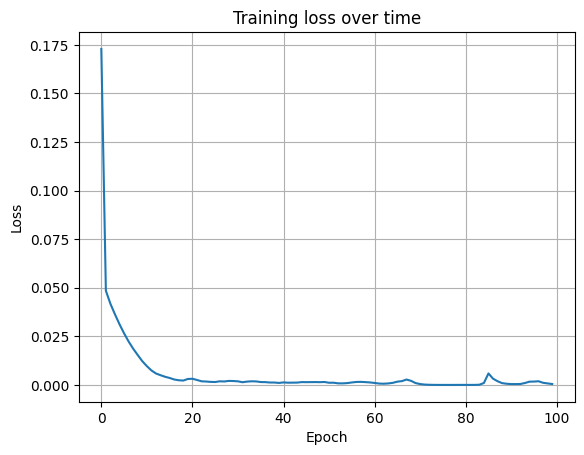

In [30]:
# plotted Losses
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss over time")
plt.grid(True)
plt.show()